# Project 1: Monte Carlo

1. Pick a physical system you’re curious about.

    <span style="color:purple">Well, originally I was going to use the hard-particle Monte Carlo module in HOOMD to make patchy trapezoids in the spirit of the tobacco mosaic virus... but interactions in hpmc are defined using just-in-time compilation--which requires HOOMD to know where to find the C-compiler--which required recompiling HOOMD--which proved to be a little difficult... I'm not giving up on it, but the stress of getting it working in two weeks was not ideal.
    Therefore the system I'm looking at is attractive particles on a periodic 3D lattice!</span>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [2]:
def init(N,L):
    """returns a list of N occupied sites and an LxLxL lattice with 0's for
       empty sites and integers >0 corresponding to non-empty sites. """
    lattice = np.zeros((L,L,L),dtype=np.int8) #Initialize empty lattice
    occupied = np.random.choice(L**3,N,replace=False)
    for site in occupied:
        lattice[site//L - L*(site//L**2)][site%L][site//L**2]= 1 #convert index on [0,V**3) to [0,V)[0,V)[0,V)
    return occupied, lattice

In [ ]:
# Random thing to visualize lattice like a Rubiks cube
#
#bool_latt = np.greater(latt,np.zeros((5,5,5)))
#
#def explode(data):
#    size = np.array(data.shape)*2
#    data_e = np.zeros(size - 1, dtype=data.dtype)
#    data_e[::2, ::2, ::2] = data
#    return data_e
#
#facecolors = np.where(bool_latt, '#FFD65DC0', '#7A88CCC0')
#edgecolors = np.where(bool_latt, '#BFAB6E', '#7D84A6')
#filled = np.ones(bool_latt.shape)
#
## upscale the above voxel image, leaving gaps
#filled_2 = explode(filled)
#fcolors_2 = explode(facecolors)
#ecolors_2 = explode(edgecolors)
#
## Shrink the gaps
#x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
#x[0::2, :, :] += 0.05
#y[:, 0::2, :] += 0.05
#z[:, :, 0::2] += 0.05
#x[1::2, :, :] += 0.95
#y[:, 1::2, :] += 0.95
#z[:, :, 1::2] += 0.95
#
#fig = plt.figure()
#ax = fig.gca(projection='3d')
#ax.voxels(x, y, z, filled_2, facecolors=fcolors_2, edgecolors=ecolors_2)
#
#plt.show()

In [3]:
def get_rcd(site, L):
    """Return row, column, and depth index given the number of the site in an 
       LxLxL periodic volume."""
    row = site//L - L*(site//L**2)
    col = site%L
    dep = site//L**2
    return (row,col,dep)

def adjacent(site,L):
    """Return a tuple with indices corresponding to the three sites adjacent
       to the one passed in, wrapping around a LxLxL periodic volume."""
    row, col, dep = get_rcd(site, L)
    
    left = ((col - 1 + L) % L) + row*L + dep*L**2
    right = ((col + 1) % L) + row*L + dep*L**2
    up =  ((row - 1 + L) % L)*L + col + dep*L**2
    down =  ((row + 1) % L)*L + col + dep*L**2
    back = ((dep + 1) % L)*L**2 + col + row*L
    forth = ((dep - 1 + L) % L)*L**2 + col + row*L
    return (right, down, back, up, left, forth)

#for x in [0,2,6,25,26,30,31,39,49,124,96,100]:
#    print(x,adjacent(x,5))

In [4]:
def edges(site,L):
    """Return a tuple with indices corresponding to the twelve sites which share 
    an edge to the one passed in, wrapping around a LxLxL periodic volume."""
    
    right, down, back, up, left, forth = adjacent(site, L) 
    drow, dcol, ddep = get_rcd(down, L)
    urow, ucol, udep = get_rcd(up, L)
    frow, fcol, fdep = get_rcd(forth, L)
    brow, bcol, bdep = get_rcd(back, L)
    
    rd = ((dcol + 1) % L) + drow*L + ddep*L**2      # right op on down
    ru = ((ucol + 1) % L) + urow*L + udep*L**2      # right op on up
    fr = ((fcol + 1) % L) + frow*L + fdep*L**2      # right op on forth
    fl = ((fcol - 1 + L) % L) + frow*L + fdep*L**2  # left op on forth
    fd = ((frow + 1) % L)*L + fcol + fdep*L**2      # down op on forth
    fu = ((frow - 1 + L) % L)*L + fcol + fdep*L**2  # up op on forth
    ld = ((dcol - 1 + L) % L) + drow*L + ddep*L**2  # left op on down
    lu = ((ucol - 1 + L) % L) + urow*L + udep*L**2  # left op on up
    br = ((bcol + 1) % L) + brow*L + bdep*L**2      # right op on back
    bl = ((bcol - 1 + L) % L) + brow*L + bdep*L**2  # left op on back
    bu = ((brow - 1 + L) % L)*L + bcol + bdep*L**2  # up op on back
    bd = ((brow + 1) % L)*L + bcol + bdep*L**2      # down op on back
    
    return (rd, fr, fd, ld, br, fu, lu, bl, bu, bd, ru, fl) 

#for x in [0,2,6,25,26,30,31,39,49,124,96,100]:
#    print(x,edges(x,5))

In [5]:
def corners(site,L):
    """Return a tuple with indices corresponding to the eight sites which share 
    an edge to the one passed in, wrapping around a LxLxL periodic volume."""
    
    rd, fr, fd, ld, br, fu, lu, bl, bu, bd, ru, fl = edges(site, L) 
    rd_row, rd_col, rd_dep = get_rcd(rd, L)
    ld_row, ld_col, ld_dep = get_rcd(ld, L)
    ru_row, ru_col, ru_dep = get_rcd(ru, L)
    lu_row, lu_col, lu_dep = get_rcd(lu, L)
    
    brd = ((rd_dep + 1) % L)*L**2 + rd_col + rd_row*L      # back op on right-down
    frd = ((rd_dep - 1 + L) % L)*L**2 + rd_col + rd_row*L  # forth op on right-down
    fld = ((ld_dep - 1 + L) % L)*L**2 + ld_col + ld_row*L  # forth op on left-down
    bld = ((ld_dep + 1) % L)*L**2 + ld_col + ld_row*L      # back op on left-down
    bru = ((ru_dep + 1) % L)*L**2 + ru_col + ru_row*L      # back op on right-down
    fru = ((ru_dep - 1 + L) % L)*L**2 + ru_col + ru_row*L  # forth op on right-down
    flu = ((lu_dep - 1 + L) % L)*L**2 + lu_col + lu_row*L  # forth op on left-down
    blu = ((lu_dep + 1) % L)*L**2 + lu_col + lu_row*L      # back op on left-down
    
    return (brd, frd, fld, bld, bru, fru, flu, blu)

#for x in [0,2,6,25,26,30,31,39,49,124,96,100]:
#    print(x,corners(x,5))

/Users/jennyfothergill/miniconda3/envs/jpnb/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


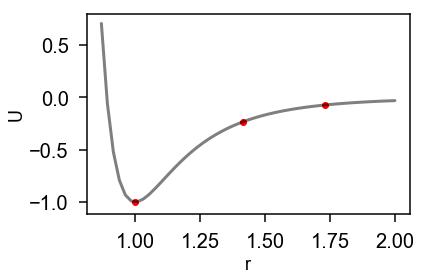

In [6]:
def v_LJ(r, epsilon=-1):
    return -epsilon*((1/r)**12-2*(1/r)**6)

vv_LJ = np.vectorize(v_LJ)
x = np.linspace(0.87,2)

plt.plot(x,vv_LJ(x),'k',alpha=0.5)
plt.scatter([1,np.sqrt(2),np.sqrt(3)],vv_LJ([1,np.sqrt(2),np.sqrt(3)]),c='red')
plt.xlabel("r", fontsize=18)
plt.ylabel("U", fontsize=18)
plt.show()

2. Determine a simple (or, as simple as possible) representation of it that balances ease of implementation with probing its thermodynamics.
    
    <span style="color:purple">I chose to represent three on-lattice distances in the LJ potential: the face, edge, and corner-sharing distances. Implemented below is a Lennard-Jones-like interaction energy where the face-adjacent lattice sites interact at the energy minimum (1.0 x epsilon), the side-adjacent sites at 0.234 x epsilon, and the corner-adjacent sites at 0.073 x epsilon.</span>


In [7]:
def energy(occupied,lattice,epsilon=-1):
    """Returns the total potential energy for the occupied sites on a lattice."""
    ep_face,ep_edge,ep_corner = vv_LJ([1,np.sqrt(2),np.sqrt(3)],epsilon)
    U = 0
    L = len(lattice)
    for site in occupied: #loop over all sites
        #print("site",site)
        for neighbor in adjacent(site,L)[:3]: #Look right and down and back, so we don't double count
            if lattice[neighbor//L - L*(neighbor//L**2)][neighbor%L][neighbor//L**2]!= 0:
                #print("face neighbor",neighbor)
                U+=ep_face
        for neighbor in edges(site,L)[:6]:
            if lattice[neighbor//L - L*(neighbor//L**2)][neighbor%L][neighbor//L**2]!= 0:
                #print("edge neighbor",neighbor)
                U+=ep_edge
        for neighbor in corners(site,L)[:4]:
            if lattice[neighbor//L - L*(neighbor//L**2)][neighbor%L][neighbor//L**2]!= 0:
                #print("corner neighbor",neighbor)
                U+=ep_corner
    return U

In [18]:
## Test with 5x5x5 lattice
## (uncomment print statements in above energy function)
#
#occ, latt = init(20,5)
#print("    0-24       25-49        50-74      75-99      100-124")
#for i in range(len(latt)):
#    print(latt[i,:,0],latt[i,:,1],latt[i,:,2],latt[i,:,3],latt[i,:,4],'\n',end="")
#    
#print('\n occupied:',sorted(occ),'\n')
#
#energy(sorted(occ),latt)

In [8]:
def trial_move(occupied,lattice,T):
    L=len(lattice)
    V = L**3
    Uo = energy(occupied,lattice)
    np.random.shuffle(occupied) #shuffles the elements of occupied
    old = occupied[0]
    empty_mask = np.isin(np.arange(V),occupied,invert=True)
    empty_sites = np.arange(V)[empty_mask] # list of empty sites
    new = empty_sites[np.random.randint(len(empty_sites))]
    occupied[0]= new
    lattice[new//L - L*(new//L**2)][new%L][new//L**2] = 1
    lattice[old//L - L*(old//L**2)][old%L][old//L**2] = 0
    Un = energy(occupied,lattice)
    if (Un<=Uo) or np.random.random() < np.exp(-(Un-Uo)/T):
        return occupied, lattice, Un, 1
    lattice[old//L - L*(old//L**2)][old%L][old//L**2] = 1
    lattice[new//L - L*(new//L**2)][new%L][new//L**2] = 0
    occupied[0]=old
    return occupied, lattice, Uo, 0

In [136]:
def run(nsteps,T,occupied, lattice):
    U = []
    all_occ = []
    accepted = 0
    for step in range(int(nsteps)):
        occupied, lattice, u, accept_move = trial_move(occupied, lattice, T)
        accepted += accept_move
        U.append(u)
        all_occ.append(np.copy(occupied))
    return np.array(U)/len(occupied), accepted, all_occ

def analyze(data):
    a = np.average(data)
    s = np.std(data)
    return a,s

In [63]:
Temps = np.arange(0.1,2.,0.1)
Sizes = range(10,100,10) 
nsteps = 1e3

In [11]:
#results = {}
#all_runs = {}
#for N in Sizes:
#    print("N = ",N)
#    onerun = []
#    for T in Temps:
#        print("\t T = {0:.1f}".format(T))
#        occupied, lattice = init(N,10) # N, L
#        start = time.time()
#        U, accepted, all_occ = run(nsteps,T,occupied, lattice)
#        a, s = analyze(U)
#        finish = time.time()
#        all_runs[(N,T)] = (U,all_occ)
#        onerun.append((a,s,finish-start,accepted/nsteps))
#    results[N] =  np.array(onerun)

N =  10
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  20
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  30
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  40
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  50
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  60
	 

In [12]:
## Whew. That's slow, let's pickle results for later, so we never have to run that again.
#with open("results.p", "wb") as f:
#    pickle.dump(results,f)
#    
#with open("all_runs.p", "wb") as f:
#    pickle.dump(all_runs,f)

In [11]:
with open("results.p", "rb") as f:
    results = pickle.load(f)

with open("all_runs.p", "rb") as f:
    all_runs = pickle.load(f)

3. Characterize your model’s performance:
    
    c. Can you improve the performance of your simulation by changing the trial moves?
    
    <span style="color:purple">Because the above simulation ran SO SLOWLY, I decided to skip to part c. Our system is slow because we use a for loop to loop over **every occupied site**, but what we really care about is the change in energy. So why don't we just calculate the change in energy by just calculating the energy of the old site and the energy of the new site? That should be less calculation because we only have to look at 2 sites. ☺️</span>

In [43]:
## Test that new energy function works
#
#L = 5
#N = 40
#V = L**3
#
#occupied,lattice = init(N,L)
#
#Uo = energy(occupied,lattice)
#np.random.shuffle(occupied)
#old = occupied[0]
#Uo_del = del_energy(old,occupied,lattice)
#
#empty_mask = np.isin(np.arange(V),occupied,invert=True)
#empty_sites = np.arange(V)[empty_mask] # list of empty sites
#new = empty_sites[np.random.randint(len(empty_sites))]
#occupied[0]= new
#lattice[new//L - L*(new//L**2)][new%L][new//L**2] = 1
#lattice[old//L - L*(old//L**2)][old%L][old//L**2] = 0
#
#Un = energy(occupied,lattice)
#Un_del = del_energy(new,occupied,lattice)
#
#print("\u0394E calculated old way: {0:.3f}".format(Un-Uo))
#print("\u0394E calculated old way: {0:.3f}".format(Un_del-Uo_del))

ΔE calculated old way: 0.855
ΔE calculated old way: 0.855


In [137]:
def del_energy(site, occupied, lattice, epsilon=-1):
    """Returns the potential energy of one site on a lattice."""
    ep_face,ep_edge,ep_corner = vv_LJ([1,np.sqrt(2),np.sqrt(3)],epsilon)
    U = 0
    L = len(lattice)
    #print("site",site)
    for neighbor in adjacent(site,L): #Look everywhere
        if lattice[neighbor//L - L*(neighbor//L**2)][neighbor%L][neighbor//L**2]!= 0:
            #print("face neighbor",neighbor)
            U+=ep_face
    for neighbor in edges(site,L):
        if lattice[neighbor//L - L*(neighbor//L**2)][neighbor%L][neighbor//L**2]!= 0:
            #print("edge neighbor",neighbor)
            U+=ep_edge
    for neighbor in corners(site,L):
        if lattice[neighbor//L - L*(neighbor//L**2)][neighbor%L][neighbor//L**2]!= 0:
            #print("corner neighbor",neighbor)
            U+=ep_corner
    return U

def del_trial_move(occupied,lattice,T,energy):
    L=len(lattice)
    V = L*L*L
    
    np.random.shuffle(occupied) #shuffles the elements of occupied
    old = occupied[0]
    Uo = del_energy(old,occupied,lattice) # energy of old site
    
    empty_mask = np.isin(np.arange(V),occupied,invert=True)
    empty_sites = np.arange(V)[empty_mask] # list of empty sites
    new = empty_sites[np.random.randint(len(empty_sites))]
    occupied[0]= new
    lattice[new//L - L*(new//L**2)][new%L][new//L**2] = 1
    lattice[old//L - L*(old//L**2)][old%L][old//L**2] = 0

    Un = del_energy(new,occupied,lattice) # energy of new site
    
    if (Un<=Uo) or np.random.random() < np.exp(-(Un-Uo)/T):
        return occupied, lattice, energy + Un - Uo, 1
    lattice[old//L - L*(old//L**2)][old%L][old//L**2] = 1
    lattice[new//L - L*(new//L**2)][new%L][new//L**2] = 0
    occupied[0]=old
    return occupied, lattice, energy, 0

def del_run(nsteps,T,occupied, lattice):
    U = []
    all_occ = []
    accepted = 0
    u = energy(occupied,lattice) # calculate total energy of initial lattice
    U.append(u)
    for step in range(int(nsteps)):
        occupied, lattice, u, accept_move = del_trial_move(occupied, lattice, T, u)
        accepted += accept_move
        U.append(u)
        all_occ.append(np.copy(occupied))
    return np.array(U)/len(occupied), accepted, all_occ

In [138]:
del_results = {}
del_all_runs = {}

for N in Sizes:
    print("N = ",N)
    onerun = []
    for T in Temps:
        print("\t T = {0:.1f}".format(T))
        occupied, lattice = init(N,10) # N, L
        start = time.time()
        U, accepted, all_occ = del_run(nsteps,T,occupied, lattice)
        a, s = analyze(U)
        finish = time.time()
        del_all_runs[(N,T)] = (U,all_occ)
        onerun.append((a,s,finish-start,accepted/nsteps))
    del_results[N] =  np.array(onerun)

N =  10
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  20
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  30
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  40
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  50
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  60
	 

/Users/jennyfothergill/miniconda3/envs/jpnb/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


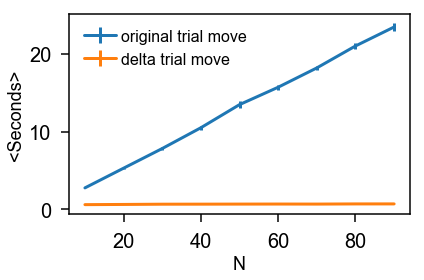

For the largest system (N=90) using the new trial move the average time for a run goes from 
23.496 to 0.713 seconds which is a speed up of 32 times!


In [108]:
# How much faster is the new trial move?

times = []
del_times = []
for N in Sizes:
    times.append((np.average(results[N][:,2]),np.std(results[N][:,2])))
    del_times.append((np.average(del_results[N][:,2]),np.std(del_results[N][:,2])))
times = np.array(times)
del_times = np.array(del_times)

plt.errorbar(Sizes,times[:,0],times[:,1],label="original trial move")
plt.errorbar(Sizes,del_times[:,0],del_times[:,1],label="delta trial move")
plt.legend(fontsize=16,loc="upper left")
plt.xlabel("N", fontsize=18)
plt.ylabel("<Seconds>", fontsize=18)
plt.show()

print("""For the largest system (N={0}) using the new trial move the average time for a run goes from 
{2:.3f} to {1:.3f} seconds which is a speed up of {3} times!""".format(Sizes[-1],del_times[-1][0],times[-1][0],
                                                                       int(times[-1][0]//del_times[-1][0])))

<span style="color:purple">Because the new trial move only has to calculate the change in energy (which is an energy calculation for 2 particles regardless of the simulation size), the simulation time no longer scales with N! That's pretty cool.</span>

3. Characterize your model’s performance:

    a. How small is too small? How big is too big?
    
    <span style="color:purple">Let's consider 3 measures of bigness: number of particles (N), size of the lattice (L), and the number of steps.</span>
    
    <span style="color:purple">N: With the new trial move, the value of N does not affect the computational cost, therefore the only limiting factors on N are common-sense ones. (i.e., it is silly to calculate a lattice which is completely full, completely empty, or which only has one particle or vacancy.)</span>
    
    <span style="color:purple">L: If L becomes extremely large enough, at some point the computer will struggle to store the lattice matrix in memory. Another problem could arise if the lattice is so small that a particle can interact with it's periodic image because that would be unphysical, so L has to be at least twice as big as the interaction length. I think I would argue that the smallest L which provides usable data is the best. My reasoning is that the density ($\frac{N}{L^{3}}$) is what we are actually interested in as a periodic box doesn't exist in reality. By using a smaller L we can sample the range of density with fewer particles. Fewer particles means that the energy will fluctuate more with each move. More fluctuations will result in shorter decorrelation times, and therfore more independent samples.</span>
    
    <span style="color:purple">number of steps: The number of steps depends on the system size, density, temperature, and most of all your patience. The ideal number of steps is the minimum needed to produce a reasonable number independent samples with low relative error.</span>

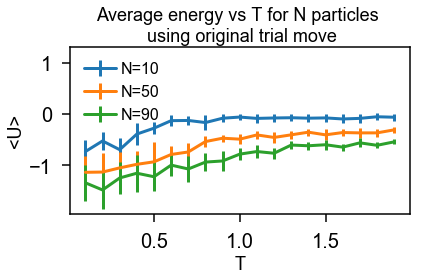

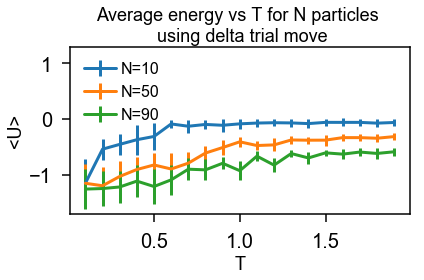

In [19]:
plt.errorbar(Temps,results[10][:,0],results[10][:,1], label="N=10")
plt.errorbar(Temps,results[50][:,0],results[50][:,1], label="N=50")
plt.errorbar(Temps,results[90][:,0],results[90][:,1], label="N=90")
plt.xlabel("T", fontsize=18)
plt.ylabel("<U>", fontsize=18)
plt.title("Average energy vs T for N particles \n using original trial move",fontsize=18)
bottom,top = plt.ylim()
plt.ylim((bottom,top+1.2))
plt.legend(fontsize=16,loc="upper left")
plt.show()

plt.errorbar(Temps,del_results[10][:,0],del_results[10][:,1], label="N=10")
plt.errorbar(Temps,del_results[50][:,0],del_results[50][:,1], label="N=50")
plt.errorbar(Temps,del_results[90][:,0],del_results[90][:,1], label="N=90")
plt.xlabel("T", fontsize=18)
plt.ylabel("<U>", fontsize=18)
plt.title("Average energy vs T for N particles \n using delta trial move",fontsize=18)
bottom,top = plt.ylim()
plt.ylim((bottom,top+1.2))
plt.legend(fontsize=16,loc="upper left")
plt.show()

<span style="color:purple">Good, looks like the new trial move does not change the relationship between energy and temperature.</span>

3. Characterize your model’s performance:

    a. How long does it take to equilibrate at extremes of state?
    
    <span style="color:purple">OK so now that we have this much faster MC algorithm let's actually do some science. I understand "extremes of state" to mean high/low T and high/low density.
Below are the trajectories from the EXTREME runs.</span>

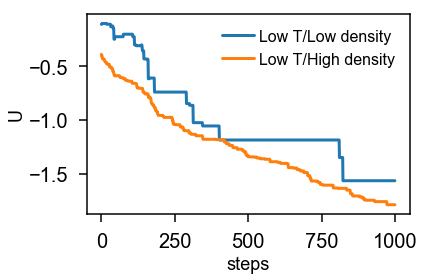

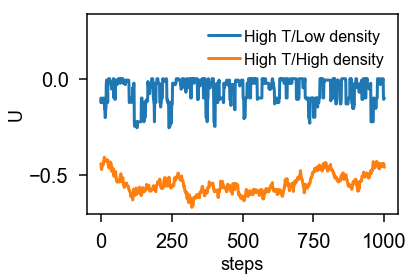

In [109]:
plt.plot(del_all_runs[(Sizes[0],Temps[0])][0],label="Low T/Low density")
plt.plot(del_all_runs[(Sizes[-1],Temps[0])][0],label="Low T/High density")
plt.xlabel("steps", fontsize=18)
plt.ylabel("U", fontsize=18)
plt.legend(fontsize=16,loc="upper right")
plt.show()

plt.plot(del_all_runs[(Sizes[0],Temps[-1])][0],label="High T/Low density")
plt.plot(del_all_runs[(Sizes[-1],Temps[-1])][0],label="High T/High density")
plt.xlabel("steps", fontsize=18)
plt.ylabel("U", fontsize=18)
bot,top = plt.ylim()
plt.ylim((bot,top+0.3))
plt.legend(fontsize=16,loc="upper right")
plt.show()

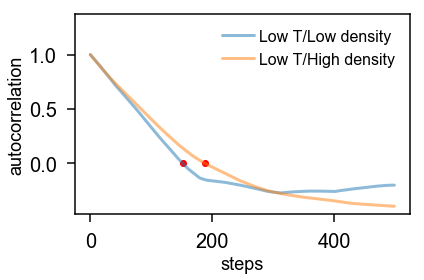

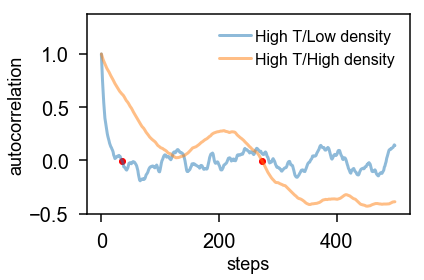

		 steps until decorrelated 	 # of independent samples
Low T/Low density:   	152 				 6
Low T/High density:  	188 				 5
High T/Low density:  	35 				 28
High T/High density: 	273 				 3


Average energy (all samples)
Low T/Low density:   -1.021 +/- 0.424 (rel error 1.31%)
Low T/High density:  -1.258 +/- 0.375 (rel error 0.94%)
High T/Low density:  -0.060 +/- 0.065 (rel error 3.44%)
High T/High density: -0.542 +/- 0.051 (rel error 0.30%)


Average energy (independent samples sampled from beginning)
Low T/Low density:   -0.932 +/- 0.467 (rel error 18.96%)
Low T/High density:  -1.200 +/- 0.455 (rel error 15.47%)
High T/Low density:  -0.068 +/- 0.059 (rel error 16.12%)
High T/High density: -0.499 +/- 0.054 (rel error 5.38%)


Average energy (independent samples sampled from end)
Low T/Low density:   -1.070 +/- 0.444 (rel error 15.69%)
Low T/High density:  -1.281 +/- 0.396 (rel error 12.63%)
High T/Low density:  -0.049 +/- 0.062 (rel error 23.41%)
High T/High density: -0.536 +/- 0.045 (rel

In [110]:
def autocorr1D(array):
    '''Takes in a linear numpy array, performs autocorrelation
       function and returns normalized array with half the length 
       of the input'''
    ft = np.fft.rfft(array-np.average(array)) 
    acorr = np.fft.irfft(ft*np.conjugate(ft))/(len(array)*np.var(array))
    return acorr[0:len(acorr)//2]

def get_decorr(acorr):
    return np.argmin(acorr>0)

def error_analysis(data):
    """Returns the standard and relative error given a dataset in a 1D numpy array"""
    serr = np.std(data)/np.sqrt(len(data))
    rel_err = np.abs(100* serr/np.average(data))
    return (serr, rel_err)
        
u1 = del_all_runs[(Sizes[0],Temps[0])][0]
u2 = del_all_runs[(Sizes[-1],Temps[0])][0]
u3 = del_all_runs[(Sizes[0],Temps[-1])][0]
u4 = del_all_runs[(Sizes[-1],Temps[-1])][0]    
        
a1 = autocorr1D(u1)
a2 = autocorr1D(u2)
a3 = autocorr1D(u3)
a4 = autocorr1D(u4)

dt1 = get_decorr(a1)
dt2 = get_decorr(a2)
dt3 = get_decorr(a3)
dt4 = get_decorr(a4)

plt.plot(a1,label="Low T/Low density",alpha=0.5)
plt.plot(a2,label="Low T/High density",alpha=0.5)
plt.scatter([dt1,dt2],[a1[dt1],a2[dt2]],c='r')
plt.xlabel("steps", fontsize=18)
plt.ylabel("autocorrelation", fontsize=18)
bot,top = plt.ylim()
plt.ylim((bot,top+0.3))
plt.legend(fontsize=16,loc="upper right")
plt.show()

plt.plot(a3,label="High T/Low density",alpha=0.5)
plt.plot(a4,label="High T/High density",alpha=0.5)
plt.scatter([dt3,dt4],[a3[dt3],a4[dt4]],c='r')
plt.legend(loc="upper right")
plt.xlabel("steps", fontsize=18)
plt.ylabel("autocorrelation", fontsize=18)
bot,top = plt.ylim()
plt.ylim((bot,top+0.3))
plt.legend(fontsize=16,loc="upper right")
plt.show()

print("""\t\t steps until decorrelated \t # of independent samples
Low T/Low density:   \t{0} \t\t\t\t {1}
Low T/High density:  \t{2} \t\t\t\t {3}
High T/Low density:  \t{4} \t\t\t\t {5}
High T/High density: \t{6} \t\t\t\t {7}""".format(dt1,int(nsteps//dt1),dt2,int(nsteps//dt2),
                                                     dt3,int(nsteps//dt3),dt4,int(nsteps//dt4)))


print("\n\nAverage energy (all samples)")
print("Low T/Low density:   {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u1),
                                                                             np.std(u1),
                                                                             error_analysis(u1)[1]))
print("Low T/High density:  {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u2),
                                                                             np.std(u2),
                                                                             error_analysis(u2)[1]))
print("High T/Low density:  {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u3),
                                                                             np.std(u3),
                                                                             error_analysis(u3)[1]))
print("High T/High density: {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u4),
                                                                             np.std(u4),
                                                                             error_analysis(u4)[1]))

print("\n\nAverage energy (independent samples sampled from beginning)")
print("Low T/Low density:   {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u1[::dt1]),
                                                                             np.std(u1[::dt1]),
                                                                             error_analysis(u1[::dt1])[1]))
print("Low T/High density:  {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u2[::dt2]),
                                                                             np.std(u2[::dt2]),
                                                                             error_analysis(u2[::dt2])[1]))
print("High T/Low density:  {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u3[::dt3]),
                                                                             np.std(u3[::dt3]),
                                                                             error_analysis(u3[::dt3])[1]))
print("High T/High density: {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u4[::dt4]),
                                                                             np.std(u4[::dt4]),
                                                                             error_analysis(u4[::dt4])[1]))

print("\n\nAverage energy (independent samples sampled from end)")
print("Low T/Low density:   {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u1[::-dt1]),
                                                                             np.std(u1[::-dt1]),
                                                                             error_analysis(u1[::-dt1])[1]))
print("Low T/High density:  {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u2[::-dt2]),
                                                                             np.std(u2[::-dt2]),
                                                                             error_analysis(u2[::-dt2])[1]))
print("High T/Low density:  {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u3[::-dt3]),
                                                                             np.std(u3[::-dt3]),
                                                                             error_analysis(u3[::-dt3])[1]))
print("High T/High density: {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u4[::-dt4]),
                                                                             np.std(u4[::-dt4]),
                                                                             error_analysis(u4[::-dt4])[1]))

<span style="color:purple">The average energies look OK, but when we look at the independent samples it becomes pretty clear that where we start our independence sampling can make a big impact on the average energy and the relative errors are huge. This suggests the system is still equilibrating. But now that the trial move algorithm is fast, we can run it for more steps, no sweat!</span> 

In [22]:
long_results = {}
long_all_runs = {}
nsteps = 1e4

for N in Sizes:
    print("N = ",N)
    onerun = []
    for T in Temps:
        print("\t T = {0:.1f}".format(T))
        occupied, lattice = init(N,10) # N, L
        start = time.time()
        U, accepted, all_occ = del_run(nsteps,T,occupied, lattice)
        a, s = analyze(U)
        finish = time.time()
        long_all_runs[(N,T)] = (U,all_occ)
        onerun.append((a,s,finish-start,accepted/nsteps))
    long_results[N] =  np.array(onerun)

N =  10
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  20
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  30
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  40
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  50
	 T = 0.1
	 T = 0.2
	 T = 0.3
	 T = 0.4
	 T = 0.5
	 T = 0.6
	 T = 0.7
	 T = 0.8
	 T = 0.9
	 T = 1.0
	 T = 1.1
	 T = 1.2
	 T = 1.3
	 T = 1.4
	 T = 1.5
	 T = 1.6
	 T = 1.7
	 T = 1.8
	 T = 1.9
N =  60
	 

In [23]:
## Again, let's pickle results for later, so we never have to run that again.
#with open("long_results.p", "wb") as f:
#    pickle.dump(long_results,f)
#    
#with open("long_all_runs.p", "wb") as f:
#    pickle.dump(long_all_runs,f)

In [ ]:
with open("long_results.p", "rb") as f:
    long_results = pickle.load(f)

with open("long_all_runs.p", "rb") as f:
    long_all_runs = pickle.load(f)

/Users/jennyfothergill/miniconda3/envs/jpnb/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


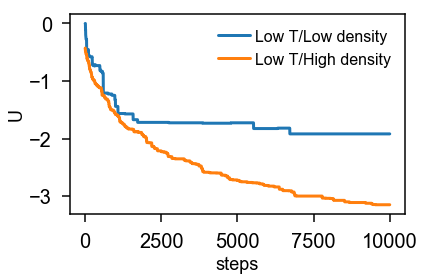

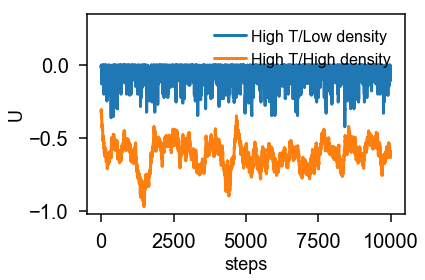

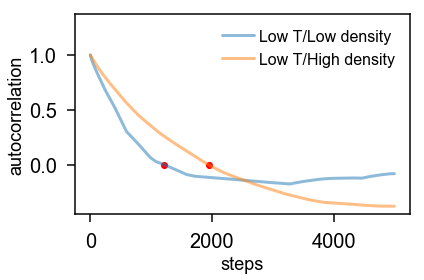

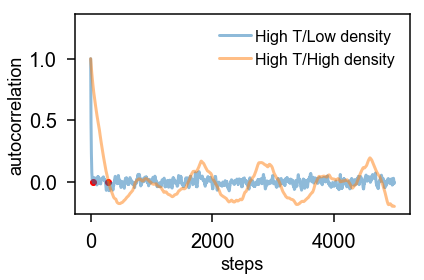

		 steps until decorrelated 	 # of independent samples
Low T/Low density:   	1220 				 0
Low T/High density:  	1947 				 0
High T/Low density:  	43 				 23
High T/High density: 	293 				 3


Average energy (all samples)
Low T/Low density:   -1.706 +/- 0.309 (rel error 0.18%)
Low T/High density:  -2.512 +/- 0.617 (rel error 0.25%)
High T/Low density:  -0.061 +/- 0.068 (rel error 1.11%)
High T/High density: -0.613 +/- 0.091 (rel error 0.15%)


Average energy (independent samples sampled from beginning)
Low T/Low density:   -1.591 +/- 0.574 (rel error 12.02%)
Low T/High density:  -2.327 +/- 0.931 (rel error 16.33%)
High T/Low density:  -0.061 +/- 0.071 (rel error 7.58%)
High T/High density: -0.604 +/- 0.106 (rel error 2.96%)


Average energy (independent samples sampled from end)
Low T/Low density:   -1.670 +/- 0.358 (rel error 7.14%)
Low T/High density:  -2.455 +/- 0.737 (rel error 12.26%)
High T/Low density:  -0.064 +/- 0.065 (rel error 6.66%)
High T/High density: -0.604 +/- 0.090 (rel 

In [164]:
u1 = long_all_runs[(Sizes[0],Temps[0])]
u2 = long_all_runs[(Sizes[-1],Temps[0])]
u3 = long_all_runs[(Sizes[0],Temps[-1])]
u4 = long_all_runs[(Sizes[-1],Temps[-1])]    
        
a1 = autocorr1D(u1)
a2 = autocorr1D(u2)
a3 = autocorr1D(u3)
a4 = autocorr1D(u4)

dt1 = get_decorr(a1)
dt2 = get_decorr(a2)
dt3 = get_decorr(a3)
dt4 = get_decorr(a4)

plt.plot(u1,label="Low T/Low density")
plt.plot(u2,label="Low T/High density")
plt.xlabel("steps", fontsize=18)
plt.ylabel("U", fontsize=18)
plt.legend(fontsize=16,loc="upper right")
plt.show()

plt.plot(u3,label="High T/Low density")
plt.plot(u4,label="High T/High density")
plt.xlabel("steps", fontsize=18)
plt.ylabel("U", fontsize=18)
bot,top = plt.ylim()
plt.ylim((bot,top+0.3))
plt.legend(fontsize=16,loc="upper right")
plt.show()

plt.plot(a1,label="Low T/Low density",alpha=0.5)
plt.plot(a2,label="Low T/High density",alpha=0.5)
plt.scatter([dt1,dt2],[a1[dt1],a2[dt2]],c='r')
plt.xlabel("steps", fontsize=18)
plt.ylabel("autocorrelation", fontsize=18)
bot,top = plt.ylim()
plt.ylim((bot,top+0.3))
plt.legend(fontsize=16,loc="upper right")
plt.show()

plt.plot(a3,label="High T/Low density",alpha=0.5)
plt.plot(a4,label="High T/High density",alpha=0.5)
plt.scatter([dt3,dt4],[a3[dt3],a4[dt4]],c='r')
plt.legend(loc="upper right")
plt.xlabel("steps", fontsize=18)
plt.ylabel("autocorrelation", fontsize=18)
bot,top = plt.ylim()
plt.ylim((bot,top+0.3))
plt.legend(fontsize=16,loc="upper right")
plt.show()

print("""\t\t steps until decorrelated \t # of independent samples
Low T/Low density:   \t{0} \t\t\t\t {1}
Low T/High density:  \t{2} \t\t\t\t {3}
High T/Low density:  \t{4} \t\t\t\t {5}
High T/High density: \t{6} \t\t\t\t {7}""".format(dt1,int(nsteps//dt1),dt2,int(nsteps//dt2),
                                                     dt3,int(nsteps//dt3),dt4,int(nsteps//dt4)))


print("\n\nAverage energy (all samples)")
print("Low T/Low density:   {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u1),
                                                                             np.std(u1),
                                                                             error_analysis(u1)[1]))
print("Low T/High density:  {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u2),
                                                                             np.std(u2),
                                                                             error_analysis(u2)[1]))
print("High T/Low density:  {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u3),
                                                                             np.std(u3),
                                                                             error_analysis(u3)[1]))
print("High T/High density: {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u4),
                                                                             np.std(u4),
                                                                             error_analysis(u4)[1]))

print("\n\nAverage energy (independent samples sampled from beginning)")
print("Low T/Low density:   {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u1[::dt1]),
                                                                             np.std(u1[::dt1]),
                                                                             error_analysis(u1[::dt1])[1]))
print("Low T/High density:  {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u2[::dt2]),
                                                                             np.std(u2[::dt2]),
                                                                             error_analysis(u2[::dt2])[1]))
print("High T/Low density:  {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u3[::dt3]),
                                                                             np.std(u3[::dt3]),
                                                                             error_analysis(u3[::dt3])[1]))
print("High T/High density: {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u4[::dt4]),
                                                                             np.std(u4[::dt4]),
                                                                             error_analysis(u4[::dt4])[1]))

print("\n\nAverage energy (independent samples sampled from end)")
print("Low T/Low density:   {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u1[::-dt1]),
                                                                             np.std(u1[::-dt1]),
                                                                             error_analysis(u1[::-dt1])[1]))
print("Low T/High density:  {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u2[::-dt2]),
                                                                             np.std(u2[::-dt2]),
                                                                             error_analysis(u2[::-dt2])[1]))
print("High T/Low density:  {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u3[::-dt3]),
                                                                             np.std(u3[::-dt3]),
                                                                             error_analysis(u3[::-dt3])[1]))
print("High T/High density: {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u4[::-dt4]),
                                                                             np.std(u4[::-dt4]),
                                                                             error_analysis(u4[::-dt4])[1]))

<span style="color:purple">So the relative error gets a little better and with the longer run it doesn't seem to matter as much whether we sample starting at the ened or the beginning. Looking at the energy trajectories it looks like the high temperature runs have random fluctuations about the average while the low temperature run appears to still be decreasing. The relative error for the high T runs is better too. To answer the question how long it takes to equilibrate, I'd say it takes more steps at low T and for all extremes were not equilibrated by 1000 steps.</span>

/Users/jennyfothergill/miniconda3/envs/jpnb/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


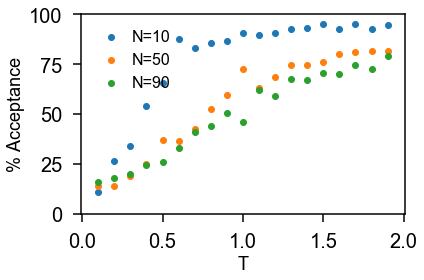

In [57]:
plt.scatter(Temps,del_results[10][:,3]*100, label="N=10")
plt.scatter(Temps,del_results[50][:,3]*100, label="N=50")
plt.scatter(Temps,del_results[90][:,3]*100, label="N=90")
plt.xlabel("T", fontsize=18)
plt.ylabel("% Acceptance", fontsize=18)

plt.ylim((0,100))
plt.legend(fontsize=16,loc="upper left")
plt.show()

<span style="color:purple"> Just to check that the temperature range I'm looking at is reasonable: OK, so this range of acceptance percentages looks good to me. It would be troubling if all or none of the moves were accepted. I'm not sure exactly what acceptance percentage is desirable--it probably depends on the system, but because a decent range is shown here (~10-90%), we can choose a temperature to suit just about any situation.</span>

4. Contrast your system with an ideal gas:

    a. How does the structure of your model vary with state, and how does it compare to particles with no interactions?
    
    <span style="color:purple">To compare the structure, let's use the radial distribution function. Below I will compare the initial and final structures of each of the extreme runs. Because the initial structure is randomly generated and has not been modified according to the MC algorithm, we can think of it as being ideal-gas-like.</span>

In [184]:
def pbc(d,L):
    return d - L * ((d+L/2)//L)

def occ_to_coords(occupied,L):
    coords = []
    for site in occupied:
        coords.append(get_rcd(site,L))
    return np.array(coords) 
    
    
def rdf(coords,L,dr):
    V = L**3
    rmax = L/2
    nbins = int(rmax//dr)
    r = np.array([i*dr for i in range(nbins)])    
    bins = np.zeros(nbins)
    for i,a in enumerate(coords[:-1]):#all but the last
        for b in coords[i+1:]:
            delta = b-a
            for h in range(3): # changed to 3D
                delta[h] = pbc(delta[h],L)
            d = np.absolute(np.linalg.norm(delta))
            index = int(d//dr)
            if index<nbins:
                bins[index] += 1 
    for i, b in enumerate(bins):
        bins[i] /= N*(N-1)/2 * np.pi*(4*(dr*(i+1))**2*dr)/V #normalize by volume of annulus AND number of pairs
    #Note: Number of Pairs is N*(N-1)/2 (Sum of numbers from 1 to N-1)    
        
    return r, bins

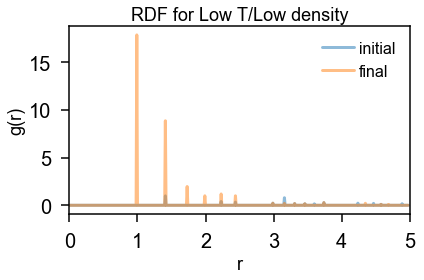

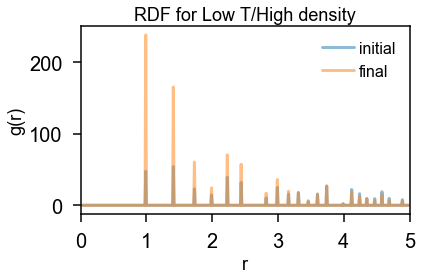

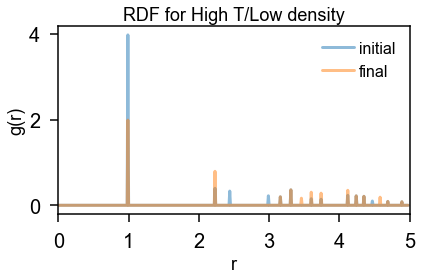

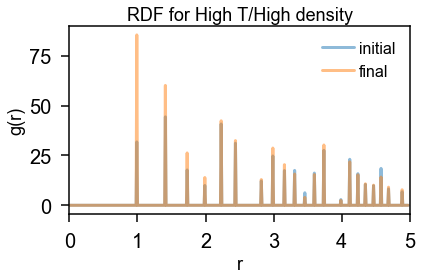

In [188]:
L = 10
dr = 0.01
coords1i = occ_to_coords(del_all_runs[(Sizes[0],Temps[0])][1][0],L)
coords2i = occ_to_coords(del_all_runs[(Sizes[-1],Temps[0])][1][0],L)
coords3i = occ_to_coords(del_all_runs[(Sizes[0],Temps[-1])][1][0],L)
coords4i = occ_to_coords(del_all_runs[(Sizes[-1],Temps[-1])][1][0],L) 
coords1f = occ_to_coords(del_all_runs[(Sizes[0],Temps[0])][1][-1],L)
coords2f = occ_to_coords(del_all_runs[(Sizes[-1],Temps[0])][1][-1],L)
coords3f = occ_to_coords(del_all_runs[(Sizes[0],Temps[-1])][1][-1],L)
coords4f = occ_to_coords(del_all_runs[(Sizes[-1],Temps[-1])][1][-1],L) 

r,bins = rdf(coords1i, L, dr)
plt.plot(r,bins,label="initial",alpha=0.5)
r,bins = rdf(coords1f, L, dr)
plt.plot(r,bins,label="final",alpha=0.5)
plt.title("RDF for Low T/Low density", fontsize=18)
plt.xlabel("r", fontsize=18)
plt.ylabel("g(r)", fontsize=18)
plt.xlim(0,5)
plt.legend(fontsize=16,loc="upper right")
plt.show()

r,bins = rdf(coords2i, L, dr)
plt.plot(r,bins,label="initial",alpha=0.5)
r,bins = rdf(coords2f, L, dr)
plt.plot(r,bins,label="final",alpha=0.5)
plt.title("RDF for Low T/High density", fontsize=18)
plt.xlabel("r", fontsize=18)
plt.ylabel("g(r)", fontsize=18)
plt.xlim(0,5)
plt.legend(fontsize=16,loc="upper right")
plt.show()

r,bins = rdf(coords3i, L, dr)
plt.plot(r,bins,label="initial",alpha=0.5)
r,bins = rdf(coords3f, L, dr)
plt.plot(r,bins,label="final",alpha=0.5)
plt.title("RDF for High T/Low density", fontsize=18)
plt.xlabel("r", fontsize=18)
plt.ylabel("g(r)", fontsize=18)
plt.xlim(0,5)
plt.legend(fontsize=16,loc="upper right")
plt.show()

r,bins = rdf(coords4i, L, dr)
plt.plot(r,bins,label="initial",alpha=0.5)
r,bins = rdf(coords4f, L, dr)
plt.plot(r,bins,label="final",alpha=0.5)
plt.title("RDF for High T/High density", fontsize=18)
plt.xlabel("r", fontsize=18)
plt.ylabel("g(r)", fontsize=18)
plt.xlim(0,5)
plt.legend(fontsize=16,loc="upper right")
plt.show()

<span style="color:purple">Those look like I'd expect from an on-lattice system: particles are only allowed to exist a discrete points on the lattice, so the distribution of distances is also discrete.
    
<span style="color:purple">We can see that at in most cases the system becomes much more closely packed, especially at low temperatures. Because the temperature--and therefore the kinetic energy--is low, once particles form an energy-lowering aggregate, it is unlikely that they will have the energy required to separate. Whereas in an ideal gas, we assume that the particles have no interaction, so all microstates are equally likely.</span>

4. Contrast your system with an ideal gas:

    b. Does the heat capacity of your system depend on state differently than  an ideal gas?
    
    <span style="color:purple">Heat capacity for an ideal gas:
\begin{equation}
C_{v} = \frac{3}{2}Nk_{b}
\end{equation}</span>

    <span style="color:purple">Equation used to calculate the heat capacity of our system:
\begin{equation}
C_{v} = \frac{1}{k_{b}T}\big(<U^{2}>-<U>^{2}\big)
\end{equation}</span>

In [189]:
# Reminder what these "u"s are:
#u1 = long_all_runs[(Sizes[0],Temps[0])]
#u2 = long_all_runs[(Sizes[-1],Temps[0])]
#u3 = long_all_runs[(Sizes[0],Temps[-1])]
#u4 = long_all_runs[(Sizes[-1],Temps[-1])]  

def cv_ideal(N):
    return 3/2*N

def cv_nonideal(U,T):
    return 1/T*(np.mean(U**2)-np.mean(U)**2)

print("Low temp/Low density heat capacity (non-ideal):   {:.3f}".format(cv_nonideal(u1[::-dt1],Temps[0])))
print("Low temp/Low density heat capacity (ideal):       {:.0f}".format(cv_ideal(Sizes[0])))
print("Low temp/High density heat capacity (non-ideal):  {:.3f}".format(cv_nonideal(u2[::-dt2],Temps[0])))
print("Low temp/High density heat capacity (ideal):      {:.0f}".format(cv_ideal(Sizes[-1])))
print("High temp/Low density heat capacity (non-ideal):  {:.3f}".format(cv_nonideal(u3[::-dt3],Temps[-1])))
print("High temp/Low density heat capacity (ideal):      {:.0f}".format(cv_ideal(Sizes[0])))
print("High temp/High density heat capacity (non-ideal): {:.3f}".format(cv_nonideal(u4[::-dt4],Temps[-1])))
print("High temp/High density heat capacity (ideal):     {:.0f}".format(cv_ideal(Sizes[-1])))

Low temp/Low density heat capacity (non-ideal):   1.279
Low temp/Low density heat capacity (ideal):       15
Low temp/High density heat capacity (non-ideal):  5.432
Low temp/High density heat capacity (ideal):      135
High temp/Low density heat capacity (non-ideal):  0.002
High temp/Low density heat capacity (ideal):      15
High temp/High density heat capacity (non-ideal): 0.004
High temp/High density heat capacity (ideal):     135


<span style="color:purple">Well that's pretty cool! (First, let me say that it doesn't make sense to quantitatively compare the values of the heat capacity between the two methods because I would need to determine kb for the system, so I am only comparing the trends seen in each method.) The heat capacity is a measure of the heat energy needed to raise the temperature (kinetic energy) of a system. The heat capacity of an ideal gas in a constant volume only depends on the number of particles because the ideal gas assumption is that the particles are non-interacting. But because our system does interact, it favors different microstates at different temperatures and will have a tendency to aggregate at low temperature in a liquid- or solid-like way. We would expect that the heat capacity of a solid would be higher than that of a gas because we are adding vibrational modes of motion; a solid has more ways of "storing" kinetic energy. (This is the reason why double-pane windows often use a gas in between the panes as a layer of insulation because the gas does not conduct heat as well as a solid.) In our Lennard-Jonesium system, we see that when the temperature is lowered and/or the density is raised (conditions which would favor solid-like behavior), the heat capacity increases.</span>

4. Contrast your system with an ideal gas:

    c. Can you derive or numerically determine an equation of state?
    
    <span style="color:purple">OK, so this is definitely doable. Here is what I am thinking: We have Cv, U, N, V, and T. ---> For most equations of state that I'm looking at we need pressure (P). In reality, we can think of pressure as the force exerted by particles on the walls of a container. In this simulation, the particles never exert force on the container because the container is periodic and the particles are never allowed to collide with anything. If we knew the particle velocities, we could calculate the pressure, but this is difficult because in the steps of our simulation particles are not moving in time... I don't want to use ideal gas assumptions (PV=nRT) because they aren't valid for this system. Instead, what if we used the acceptance percentage as a proxy for kinetic energy? I think this might work because our MC algorithm is only based on if the particle has enough kinetic energy (temperature) to move to a new location...
    
    <span style="color:purple">Or... maybe I am overthinking this and here is another equation of state we can try:
    \begin{equation}
    \frac{\delta S}{\delta T}=\frac{C_{v}}{T}
    \end{equation}</span>
    
    <span style="color:purple">Integrate both side wrt T
    \begin{equation}
    \Delta S=\int_{T_{1}}^{T_{2}} \frac{C_{v}}{T}
    \end{equation}</span>
    
    <span style="color:purple">but isn't the heat capacity a function of temperature so I can't just treat it like a constant...

5. Summarize where your model works well to give insight, where it breaks down, and any revelations that occurred while working towards 1-4

    <span style="color:purple">works well: This system models interacting particles and samples the ensemble of available microstates based on temperature. It works well for situations where we are interested in the physical interaction between particles. It can give us the potential energy, heat capacity, and, with some calibration, can be tuned to model a real system and estimate real behavior at different state points. It could model a phase change by looking at the change in the RDF with temperature.

    <span style="color:purple">breaks down: As it is now, this system can be used to model a chemical system, but to simplify it does not account for quantum chemical processes like bonding, electronic transitions, etc. It models a system of particles which can't overlap but lower the potential energy by being in adjacent lattice points. The lattice points are also fixed, so the model can't account for any change to the underlying lattice. This is not to say that a Monte Carlo technique couldn't be used to understand these phenomena, but this one doesn't currently.
    
    <span style="color:purple">revelations: I had a lot of fun with this project. I love how simple MC is and that something so simple can be used to probe complex systems.